<a href="https://colab.research.google.com/github/Bhavya-Ray/Predictive-Maintenance-for-Smart-Factories/blob/main/Predictive_Maintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Machine Learning to predict equipment failure and minimize unplanned downtime in industrial systems.

**Importing Libraries**

pandas & numpy: For data manipulation and numerical operations.

matplotlib & seaborn: For creating plots and visualizations.

train_test_split: To split data into training and testing sets.

RandomForestRegressor & XGBRegressor: The machine learning models used.

mean_squared_error, mean_absolute_error, r2_score: Metrics to evaluate regression model performance.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")


**Column Name Creation**

This line dynamically creates a list of column names for the dataset using Python's list concatenation and list comprehension:

1. 'unit_number': Unique identifier for each engine or component.

2. 'time_in_cycles': Number of operational cycles (similar to time) since the start.

3. [f'op_setting_{i+1}' for i in range(3)]: Generates names for 3 operational settings (like temperature, pressure, etc.), resulting in:

4. 'op_setting_1', 'op_setting_2', 'op_setting_3'

5. [f'sensor_measurement_{i+1}' for i in range(21)]: Generates names for 21 sensor readings, resulting in:

6. 'sensor_measurement_1' through 'sensor_measurement_21'

Together, this builds a column list of 26 features, which matches the structure of the NASA CMAPSS dataset used for predictive maintenance.

✅ Why it's useful:
Automatically generates readable and structured names.

Makes the code more scalable and reduces manual errors.


In [ ]:
column_names = ['unit_number', 'time_in_cycles'] + \
               [f'op_setting_{i+1}' for i in range(3)] + \
               [f'sensor_measurement_{i+1}' for i in range(21)]

**Load Dataset Function**

This function loads the CMAPSS dataset files for a given engine dataset number (e.g., 1, 2, 3, or 4):

Input: dataset_number – the dataset version (e.g., 1 → FD001)

🧾 Step-by-step breakdown:

1. train_df: Reads the training file which contains the full engine run-to-failure data.

2. test_df: Reads the test file which contains partial engine run data (until an unknown failure).

3. rul_df: Reads the file that contains the Remaining Useful Life (RUL) for each engine in the test set (a single number per engine).

In [ ]:
def load_dataset(dataset_number):
    # Read the three files
    train_df = pd.read_csv(f"train_FD00{dataset_number}.txt", sep="\s+", header=None)  #https://www.kaggle.com/datasets/behrad3d/nasa-cmaps?resource=download
    test_df = pd.read_csv(f"test_FD00{dataset_number}.txt", sep="\s+", header=None)
    rul_df = pd.read_csv(f"RUL_FD00{dataset_number}.txt", sep="\s+", header=None)

    # Assign column names
    train_df.columns = column_names
    test_df.columns = column_names

    return train_df, test_df, rul_df


**Loading All Datasets in a Loop**

This code loads all four available CMAPSS datasets (FD001–FD004) using the load_dataset() function defined earlier.

In [ ]:
train_sets, test_sets, rul_sets = {}, {}, {}
for i in range(1, 5):  # FD001 to FD004
    train_sets[i], test_sets[i], rul_sets[i] = load_dataset(i)

**Generating RUL (Remaining Useful Life) **

This function calculates the Remaining Useful Life (RUL) for each engine cycle in the dataset, which is a key target variable for predictive maintenance.

1. Find maximum cycles per engine:

  df.groupby('unit_number')['time_in_cycles'].max() computes the final cycle count (i.e., when the engine failed) for each engine unit.

2. Merge max cycles back into original DataFrame:

  Adds a new column max_cycle that shows the final cycle number for each unit_number.

3. Calculate RUL:

  RUL = max_cycle - time_in_cycles

  For each row (i.e., each time step for a unit), this computes how many cycles are left before failure.

4. Drop helper column:

  Removes the now-unnecessary max_cycle column for cleanliness.



In [ ]:
def create_rul_labels(df):
    max_cycle = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
    max_cycle.columns = ['unit_number', 'max_cycle']
    df = df.merge(max_cycle, on='unit_number', how='left')
    df['RUL'] = df['max_cycle'] - df['time_in_cycles']
    df.drop('max_cycle', axis=1, inplace=True)
    return df

**Scaling Sensor Data Using Min-Max Normalization**

This function normalizes sensor measurements to bring all values within a common scale (typically 0 to 1). This is crucial for improving the performance and convergence speed of most machine learning models.

In [ ]:
def scale_dataset(df, sensor_cols):
    scaler = MinMaxScaler()
    df[sensor_cols] = scaler.fit_transform(df[sensor_cols])
    return df

**Applying RUL Labeling and Scaling to All Datasets**

This block prepares all four training datasets (FD001–FD004) by:

1. Adding the Remaining Useful Life (RUL) label.

2. Scaling the sensor measurements.


In [ ]:
sensor_cols = [f'sensor_measurement_{i+1}' for i in range(21)]
for i in range(1, 5):
    train_sets[i] = create_rul_labels(train_sets[i])
    train_sets[i] = scale_dataset(train_sets[i], sensor_cols)

**Merging Test Data with RUL Labels**

This code merges each test dataset (FD001 to FD004) with its corresponding true Remaining Useful Life (RUL) values from the ground truth file, creating a DataFrame that holds the last known cycle of each engine in the test set and its actual RUL.

In [ ]:
def merge_test_with_rul(test_df, rul_df):
    max_cycle = test_df.groupby('unit_number')['time_in_cycles'].max().reset_index()
    max_cycle.columns = ['unit_number', 'max_cycle']
    rul_df.columns = ['RUL']
    rul_df['unit_number'] = max_cycle['unit_number']
    test_rul = max_cycle.merge(rul_df, on='unit_number', how='left')
    return test_rul
for i in range(1, 5):
    test_sets[i] = merge_test_with_rul(test_sets[i], rul_sets[i])

In [ ]:
print("✅ Loaded and Preprocessed FD001–FD004")
print("\n📊 FD001 Sample:")
print(train_sets[1].head())


✅ Loaded and Preprocessed FD001–FD004

📊 FD001 Sample:
   unit_number  time_in_cycles  op_setting_1  op_setting_2  op_setting_3  \
0            1               1       -0.0007       -0.0004         100.0   
1            1               2        0.0019       -0.0003         100.0   
2            1               3       -0.0043        0.0003         100.0   
3            1               4        0.0007        0.0000         100.0   
4            1               5       -0.0019       -0.0002         100.0   

   sensor_measurement_1  sensor_measurement_2  sensor_measurement_3  \
0                   0.0              0.183735              0.406802   
1                   0.0              0.283133              0.453019   
2                   0.0              0.343373              0.369523   
3                   0.0              0.343373              0.256159   
4                   0.0              0.349398              0.257467   

   sensor_measurement_4  sensor_measurement_5  ...  sensor_me

**Visualizing Engine Lifespan Distribution (FD001)**

This code creates a histogram to show the distribution of engine lifespans (measured in cycles until failure) for the FD001 training dataset. It's an essential step in exploratory data analysis (EDA) to understand how long engines typically run before failing.

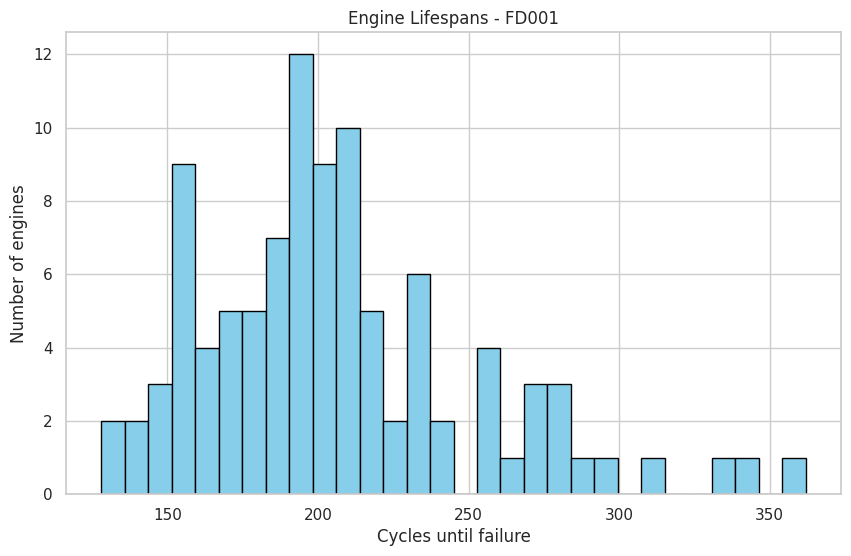

In [ ]:
plt.figure(figsize=(10, 6))
lifespans = train_sets[1].groupby("unit_number")["time_in_cycles"].max()
lifespans.hist(bins=30, color="skyblue", edgecolor="black")
plt.title("Engine Lifespans - FD001")
plt.xlabel("Cycles until failure")
plt.ylabel("Number of engines")
plt.grid(True)
plt.show()

**Combining and Shuffling CMAPSS Datasets**

This code merges all four CMAPSS training datasets (FD001–FD004) into a single combined DataFrame called combined_df. This enables unified model training and analysis across datasets with different operating conditions and fault modes.


In [ ]:
# Add a column to identify which dataset the row came from
for i in range(1, 5):
    train_sets[i]['dataset_id'] = i  # FD001 -> 1, FD002 -> 2, etc.

# Concatenate all datasets into a single DataFrame
combined_df = pd.concat([train_sets[i] for i in range(1, 5)], ignore_index=True)

# Optional: shuffle the data (if needed for training stability)
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# View shape and preview
print("✅ Combined CMAPSS Train Set Shape:", combined_df.shape)
combined_df.head()

✅ Combined CMAPSS Train Set Shape: (160359, 28)


,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,RUL,dataset_id
0,98,160,42.0050,0.8415,100.0,0.000000,0.135701,0.333279,0.272999,0.000000,...,0.542319,0.409673,0.0,0.333333,0.627907,1.0,0.010631,0.011775,7,2
1,76,198,0.0011,0.0004,100.0,0.000000,0.683735,0.617833,0.673363,0.000000,...,0.145319,0.677953,0.0,0.833333,0.000000,0.0,0.348837,0.260840,12,1
2,29,41,35.0015,0.8401,100.0,0.060269,0.179925,0.319843,0.225774,0.146592,...,0.535774,0.347247,0.0,0.322917,0.651163,1.0,0.164609,0.172200,110,2
3,112,2,42.0014,0.8408,100.0,0.000000,0.124874,0.300989,0.237063,0.000000,...,0.597753,0.346807,0.0,0.281250,0.627907,1.0,0.023320,0.023186,376,2
4,216,43,10.0022,0.2514,100.0,0.597937,0.632260,0.697738,0.669499,0.617180,...,0.674037,0.107059,1.0,0.687500,0.854123,1.0,0.636488,0.632261,186,2


**Engine Lifespan Distribution Across CMAPSS Datasets (FD001–FD004)**

This code visualizes the distribution of engine lifespans (i.e., number of operational cycles until failure) across the four CMAPSS datasets: FD001, FD002, FD003, and FD004.

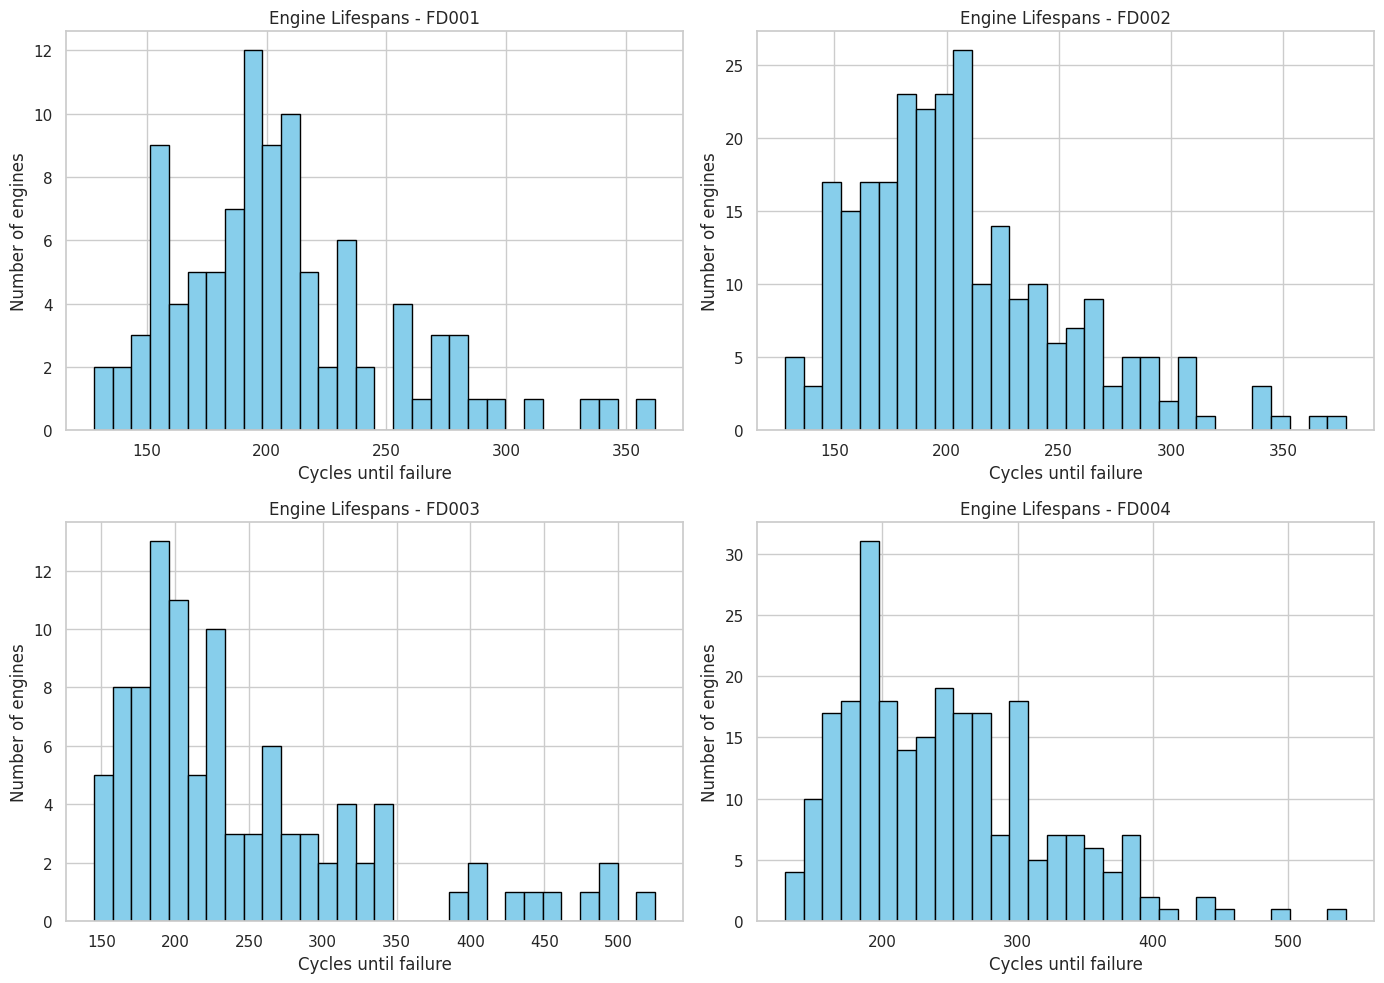

In [ ]:
import matplotlib.pyplot as plt

# Set up the subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Titles for datasets
titles = ['FD001', 'FD002', 'FD003', 'FD004']

# Loop over each dataset
for i in range(4):
    dataset_id = i + 1
    ax = axes[i]

    # Filter and get lifespans
    df = combined_df[combined_df['dataset_id'] == dataset_id]
    lifespans = df.groupby("unit_number")["time_in_cycles"].max()

    # Plot histogram
    ax.hist(lifespans, bins=30, color="skyblue", edgecolor="black")
    ax.set_title(f"Engine Lifespans - {titles[i]}")
    ax.set_xlabel("Cycles until failure")
    ax.set_ylabel("Number of engines")
    ax.grid(True)

plt.tight_layout()
plt.show()


**Modeling Remaining Useful Life (RUL) with XGBoost and Random Forest**

To predict the Remaining Useful Life (RUL) of engines using two powerful ensemble learning models:

XGBoost Regressor

Random Forest Regressor

In [ ]:
# === MODELING: XGBoost & Random Forest ===
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Define features and target
features = [col for col in combined_df.columns if "sensor_measurement" in col or "op_setting" in col]
target = 'RUL'

X = combined_df[features]
y = combined_df[target]

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# --- XGBoost Model ---
xgb = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_val)

print("\n📊 XGBoost Performance:")
print("MAE:", mean_absolute_error(y_val, y_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_xgb)))
print("R2 Score:", r2_score(y_val, y_pred_xgb))

# --- Random Forest Model ---
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

print("\n📊 Random Forest Performance:")
print("MAE:", mean_absolute_error(y_val, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_rf)))
print("R2 Score:", r2_score(y_val, y_pred_rf))


📊 XGBoost Performance:
MAE: 37.39487075805664
RMSE: 51.99346178472227
R2 Score: 0.6136424541473389

📊 Random Forest Performance:
MAE: 38.098724496492935
RMSE: 53.16114073063197
R2 Score: 0.5960937829822852


**Load and View the Data**

Loads the AI4I 2020 Predictive Maintenance dataset from a CSV file.

df.head() displays the first 5 rows to give a quick overview of the data.

In [ ]:
# === 1. LOAD AI4I 2020 DATASET ===
df_ai4i = pd.read_csv("ai4i2020.csv") #https://www.kaggle.com/datasets/stephanmatzka/predictive-maintenance-dataset-ai4i-2020?resource=download
print("✅ Dataset Loaded!")

# === 2. QUICK INSPECTION ===
print("\n📄 First 5 rows:")
print(df_ai4i.head())

print("\n📊 Dataset Info:")
print(df_ai4i.info())

print("\n🔍 Missing values:")
print(df_ai4i.isnull().sum())


✅ Dataset Loaded!

📄 First 5 rows:
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0

**Data Cleaning: AI4I 2020 Predictive Maintenance Dataset**

Prepare the raw AI4I dataset for machine learning by removing irrelevant columns, encoding categorical features, and checking class balance for the target variable.

In [ ]:
# === CLEANING ===

# Drop identifiers
df_ai4i.drop(['UDI', 'Product ID'], axis=1, inplace=True)

# Binary encode 'Type' feature (One-hot encoding)
df_ai4i = pd.get_dummies(df_ai4i, columns=['Type'], drop_first=True)

# Map 'Machine failure' as target variable
# Already 0 (no failure) and 1 (failure), so no transformation needed

# Preview cleaned dataset
print(" Cleaned Dataset Preview:")
print(df_ai4i.head())

# Check class balance
print("\n⚖️ Class Distribution (Machine Failure):")
print(df_ai4i['Machine failure'].value_counts())


 Cleaned Dataset Preview:
   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0                298.1                    308.6                    1551   
1                298.2                    308.7                    1408   
2                298.1                    308.5                    1498   
3                298.2                    308.6                    1433   
4                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Machine failure  TWF  HDF  PWF  OSF  RNF  \
0         42.8                0                0    0    0    0    0    0   
1         46.3                3                0    0    0    0    0    0   
2         49.4                5                0    0    0    0    0    0   
3         39.5                7                0    0    0    0    0    0   
4         40.0                9                0    0    0    0    0    0   

   Type_L  Type_M  
0   False    True  
1    True   False  


**Data Preparation for Modeling: AI4I 2020 Predictive Maintenance**

To prepare the dataset for machine learning classification by splitting into training and testing sets and applying feature scaling.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# === SPLIT FEATURES AND TARGET ===
X_ai4i = df_ai4i.drop("Machine failure", axis=1)
y_ai4i = df_ai4i["Machine failure"]

# === TRAIN-TEST SPLIT ===
X_train_ai4i, X_test_ai4i, y_train_ai4i, y_test_ai4i = train_test_split(
    X_ai4i, y_ai4i, test_size=0.2, random_state=42, stratify=y_ai4i
)

# === FEATURE SCALING ===
scaler_ai4i = MinMaxScaler()
X_train_ai4i_scaled = scaler_ai4i.fit_transform(X_train_ai4i)
X_test_ai4i_scaled = scaler_ai4i.transform(X_test_ai4i)

print("✅ Data scaled and split. Ready for modeling.")


✅ Data scaled and split. Ready for modeling.


  **Machine Failure Classification: Random Forest vs XGBoost**

  To build and compare the performance of two powerful classification models — Random Forest and XGBoost — for predicting machine failure based on sensor readings and operational settings.


📊 Random Forest Results:
Accuracy: 0.999
F1 Score: 0.9850746268656716
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1932
           1       1.00      0.97      0.99        68

    accuracy                           1.00      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000



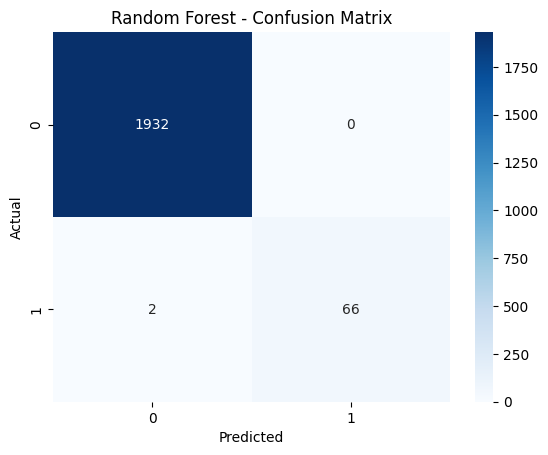


📊 XGBoost Results:
Accuracy: 0.998
F1 Score: 0.9696969696969697
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1932
           1       1.00      0.94      0.97        68

    accuracy                           1.00      2000
   macro avg       1.00      0.97      0.98      2000
weighted avg       1.00      1.00      1.00      2000



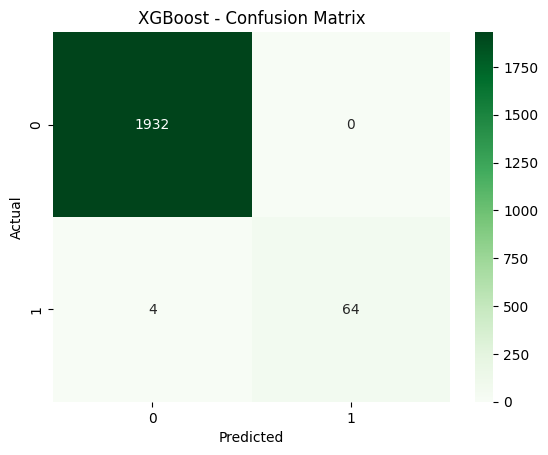

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# === RANDOM FOREST ===
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_clf.fit(X_train_ai4i_scaled, y_train_ai4i)
y_pred_rf = rf_clf.predict(X_test_ai4i_scaled)

print("\n📊 Random Forest Results:")
print("Accuracy:", accuracy_score(y_test_ai4i, y_pred_rf))
print("F1 Score:", f1_score(y_test_ai4i, y_pred_rf))
print(classification_report(y_test_ai4i, y_pred_rf))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test_ai4i, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# === XGBOOST ===
xgb_clf = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train_ai4i_scaled, y_train_ai4i)
y_pred_xgb = xgb_clf.predict(X_test_ai4i_scaled)

print("\n📊 XGBoost Results:")
print("Accuracy:", accuracy_score(y_test_ai4i, y_pred_xgb))
print("F1 Score:", f1_score(y_test_ai4i, y_pred_xgb))
print(classification_report(y_test_ai4i, y_pred_xgb))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test_ai4i, y_pred_xgb), annot=True, fmt='d', cmap='Greens')
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**Feature Importance Visualization (Random Forest)**

To understand which features (sensor measurements and operational settings) contribute most to predicting the Remaining Useful Life (RUL) in the Random Forest model.

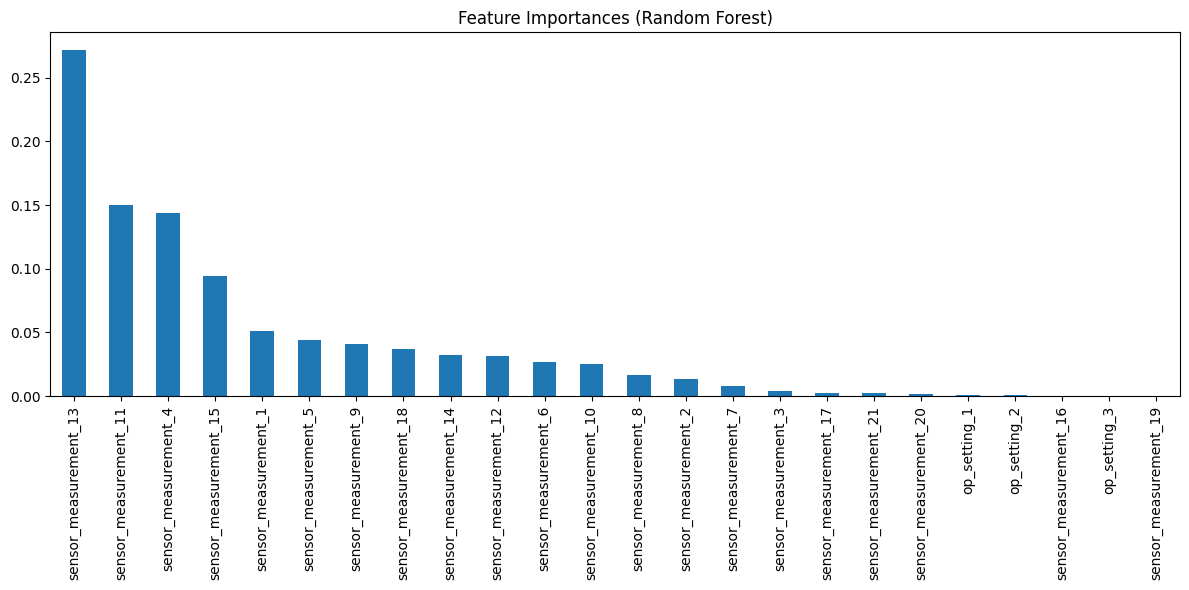

In [ ]:
# === 9. FEATURE IMPORTANCE VISUALIZATION ===
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
feat_imp.plot(kind='bar')
plt.title("Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

**Model Comparison Summary – Regression Metrics**

This section compares regression models using MAE, RMSE, and R² score to evaluate their accuracy in predicting engine Remaining Useful Life (RUL). Lower MAE/RMSE and higher R² indicate better model performance.

In [ ]:
# === 10. MODEL COMPARISON SUMMARY ===
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

In [ ]:
# Ensure you're predicting only on X_val
y_pred_rf = rf.predict(X_val)
y_pred_xgb = xgb.predict(X_val)


In [ ]:
metrics_rf = regression_metrics(y_val, y_pred_rf)
metrics_xgb = regression_metrics(y_val, y_pred_xgb)


In [ ]:
comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'MAE': [metrics_rf[0], metrics_xgb[0]],
    'RMSE': [metrics_rf[1], metrics_xgb[1]],
    'R² Score': [metrics_rf[2], metrics_xgb[2]]
})

print(comparison_df)


           Model        MAE       RMSE  R² Score
0  Random Forest  38.098724  53.161141  0.596094
1        XGBoost  37.394871  51.993462  0.613642


**Visualization: Model Performance Comparison**

This code creates a grouped bar plot comparing the performance of Random Forest, XGBoost, and a Neural Network using three regression metrics — MAE, RMSE, and R² — to visually assess which model performs best.

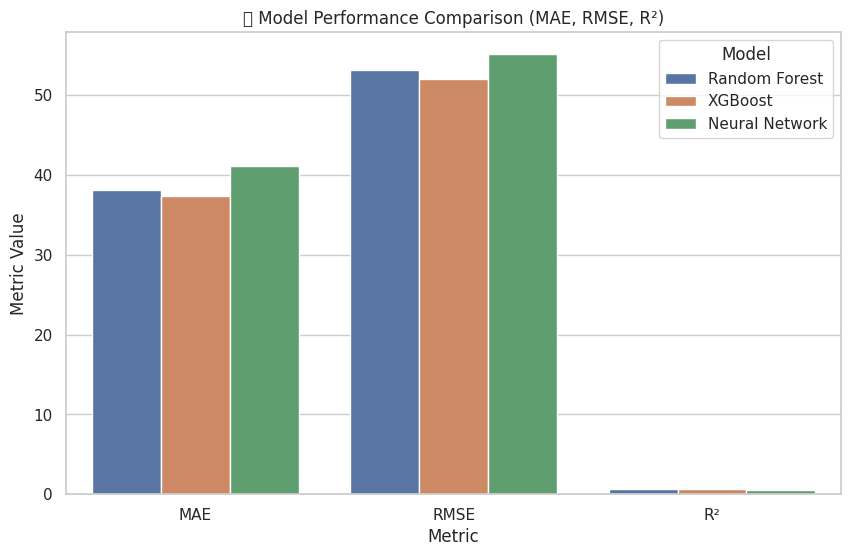

In [ ]:
# 📊 Visualization: Model Comparison Bar Plot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare DataFrame
model_metrics = pd.DataFrame({
    'Model': ['Random Forest', 'Random Forest', 'Random Forest',
              'XGBoost', 'XGBoost', 'XGBoost',
              'Neural Network', 'Neural Network', 'Neural Network'],
    'Metric': ['MAE', 'RMSE', 'R²'] * 3,
    'Value': [metrics_rf[0], metrics_rf[1], metrics_rf[2],
              metrics_xgb[0], metrics_xgb[1], metrics_xgb[2],
              nn_mae, nn_rmse, r2_nn]
})

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Value', hue='Model', data=model_metrics)
plt.title('📊 Model Performance Comparison (MAE, RMSE, R²)')
plt.ylabel('Metric Value')
plt.show()


**Cross-Validation with Sampling**

To speed up cross-validation on a large combined dataset, a 20% random sample was used. Models were evaluated using 5-fold cross-validation with R² as the scoring metric. This helps assess how well each model generalizes without training on the full dataset.

In [ ]:
# 📉 Cross-Validation with Sampling

from sklearn.model_selection import KFold, cross_val_score

# Sample 20% of the full dataset for faster cross-validation
sample_frac = 0.2  # You can adjust to 0.1 or 0.3 depending on speed vs accuracy
sampled_df = combined_df.sample(frac=sample_frac, random_state=42)

# Redefine X and y from the sampled data
X_sampled = sampled_df[sensor_cols + ['op_setting_1', 'op_setting_2', 'op_setting_3']]
y_sampled = sampled_df['RUL']

# Set up KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest CV
rf_cv_scores = cross_val_score(rf, X_sampled, y_sampled, cv=kfold, scoring='r2', n_jobs=-1)
print("Random Forest CV R² Scores:", rf_cv_scores)
print("Random Forest Mean R² Score:", np.mean(rf_cv_scores))

# XGBoost CV
xgb_cv_scores = cross_val_score(xgb, X_sampled, y_sampled, cv=kfold, scoring='r2', n_jobs=-1)
print("XGBoost CV R² Scores:", xgb_cv_scores)
print("XGBoost Mean R² Score:", np.mean(xgb_cv_scores))


Random Forest CV R² Scores: [0.58671206 0.59264092 0.5812063  0.60310068 0.57949253]
Random Forest Mean R² Score: 0.5886305002875952
XGBoost CV R² Scores: [0.59930074 0.60840839 0.59882754 0.61745071 0.59499073]
XGBoost Mean R² Score: 0.6037956237792969


**Cross-Validation R² Score Bar Plot – Sampled Data**

This bar plot compares the mean R² scores from 5-fold cross-validation for Random Forest and XGBoost, using a 20% sample of the combined dataset. Error bars indicate the standard deviation across folds, providing insight into the model stability.

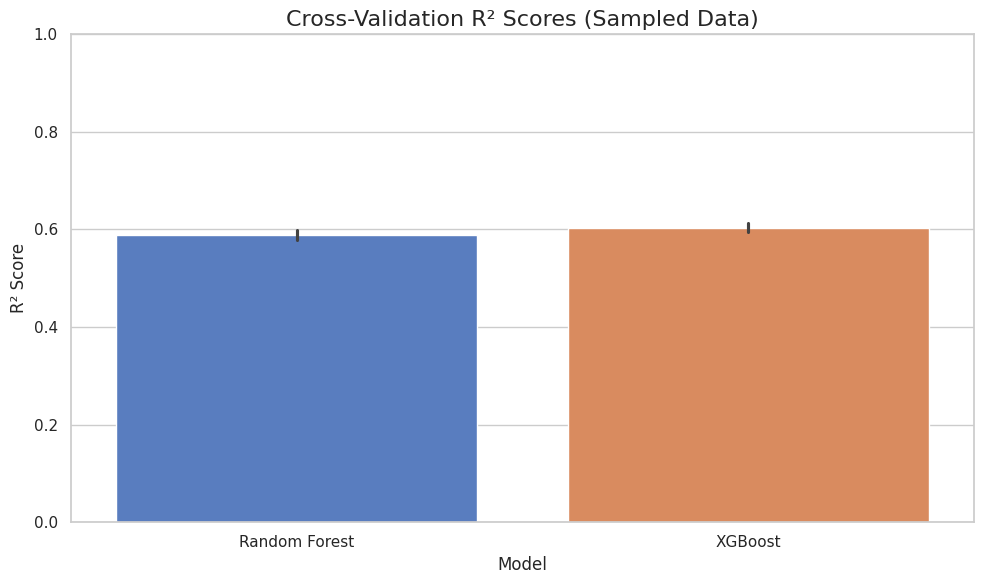

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data for plotting
cv_results = pd.DataFrame({
    'Model': ['Random Forest'] * len(rf_cv_scores) + ['XGBoost'] * len(xgb_cv_scores),
    'R² Score': list(rf_cv_scores) + list(xgb_cv_scores)
})

# Set plot style
sns.set(style="whitegrid")

# Create barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='R² Score', data=cv_results, ci='sd', palette='muted')

# Add title and labels
plt.title('Cross-Validation R² Scores (Sampled Data)', fontsize=16)
plt.ylabel('R² Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0, 1)  # Set R² score range

# Show plot
plt.tight_layout()
plt.show()


**Cross-Validation with Custom Metrics (MAE & RMSE)**

This code performs 5-fold cross-validation on the sampled dataset using Random Forest and XGBoost, calculating:

* Mean Absolute Error (MAE): Measures average absolute prediction error.
* Root Mean Squared Error (RMSE): Penalizes larger errors more heavily.

The `make_scorer` function converts these regression metrics into custom scoring functions for `cross_val_score`. Negatives are inverted to keep the scores positive for interpretability.


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error

# Custom scoring functions
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False), greater_is_better=False)

# Evaluate on sampled data
rf_mae = -cross_val_score(rf, X_sampled, y_sampled, cv=kfold, scoring=mae_scorer)
xgb_mae = -cross_val_score(xgb, X_sampled, y_sampled, cv=kfold, scoring=mae_scorer)

rf_rmse = -cross_val_score(rf, X_sampled, y_sampled, cv=kfold, scoring=rmse_scorer)
xgb_rmse = -cross_val_score(xgb, X_sampled, y_sampled, cv=kfold, scoring=rmse_scorer)


**Model Performance Summary Table**

This code block creates a summary DataFrame displaying the average performance metrics (from cross-validation) for both models:

* Mean R² Score: Indicates how well the model explains variance in the data.

* Mean MAE: Average absolute difference between actual and predicted values.

* Mean RMSE: Root of average squared differences (penalizes large errors).

The style.format() function improves readability by formatting the values neatly.


In [ ]:
summary_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Mean R² Score': [np.mean(rf_cv_scores), np.mean(xgb_cv_scores)],
    'Mean MAE': [np.mean(rf_mae), np.mean(xgb_mae)],
    'Mean RMSE': [np.mean(rf_rmse), np.mean(xgb_rmse)]
})

summary_df.style.set_caption("Model Performance Summary (Cross-Validated)").format({
    'Mean R² Score': "{:.4f}",
    'Mean MAE': "{:.2f}",
    'Mean RMSE': "{:.2f}"
})


,Model,Mean R² Score,Mean MAE,Mean RMSE
0,Random Forest,0.5886,38.53,nan
1,XGBoost,0.6038,37.94,nan


 **Neural Network Model for RUL Prediction**
This section implements a simple feedforward neural network using TensorFlow/Keras to predict Remaining Useful Life (RUL). Here's a breakdown:

* Feature Scaling: MinMaxScaler scales inputs to [0, 1] range for better neural network performance.

* Model Architecture: A 3-layer model with ReLU activations and a single output neuron for regression.

* Training: Uses MSE loss and MAE metric, trained for 20 epochs with validation monitoring.

* Evaluation: Predicts on validation set and computes R², final validation MAE, and RMSE for comparison with other models.

You can now use nn_mae, nn_rmse, and r2_nn for visualizing or comparing model performance.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import numpy as np

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build model
model = Sequential([
    Dense(64, input_dim=X_train_nn.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train model
history = model.fit(X_train_nn, y_train_nn, validation_data=(X_val_nn, y_val_nn), epochs=20, batch_size=64, verbose=1)

# 🧠 Predict on validation set using NN model
y_pred_nn = model.predict(X_val_nn).flatten()

# ✅ Calculate R² for Neural Network
r2_nn = r2_score(y_val_nn, y_pred_nn)

# ✅ Collect Neural Network metrics for radar plot
nn_mae = history.history['val_mae'][-1]
nn_rmse = np.sqrt(history.history['val_loss'][-1])
# Now you can use nn_mae, nn_rmse, and r2_nn in your radar chart section


Epoch 1/20
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 9842.6855 - mae: 76.5739 - val_loss: 5427.3535 - val_mae: 57.1698
Epoch 2/20
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 5189.6416 - mae: 56.1969 - val_loss: 4723.8203 - val_mae: 53.9705
Epoch 3/20
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 4418.7285 - mae: 51.3880 - val_loss: 3839.1125 - val_mae: 47.8195
Epoch 4/20
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 3607.9573 - mae: 45.3322 - val_loss: 3332.3320 - val_mae: 42.8948
Epoch 5/20
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3268.5852 - mae: 42.4209 - val_loss: 3247.8777 - val_mae: 41.7739
Epoch 6/20
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 3187.3899 - mae: 41.4868 - val_loss: 3206.3674 - val_mae: 42.3888
Epoch 7/20
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 3130.8467 - mae: 41.0105 - val_loss: 3135.6685 - val_mae: 40.8711
Epoch 8/20
2005/2005 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 3096.9546 - mae: 40.6480 - val_loss: 308

**R² Score Calculation for Neural Network**

This code snippet calculates the coefficient of determination (R²) for the Neural Network model

In [ ]:
from sklearn.metrics import r2_score

y_pred_nn = model.predict(X_val_nn).flatten()
r2_nn = r2_score(y_val_nn, y_pred_nn)


1003/1003 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


**Collecting All Model Metrics for Comparison**

* This creates lists of evaluation metrics for each model to enable unified comparison.

* Metrics are pulled from stored variables (e.g., metrics_rf, r2_nn, history) for later visualization or tabular summary.

In [ ]:
# Collect all metrics
model_names = ['Random Forest', 'XGBoost', 'Neural Network']
mae_scores = [metrics_rf[0], metrics_xgb[0], history.history['val_mae'][-1]]
rmse_scores = [metrics_rf[1], metrics_xgb[1], np.sqrt(history.history['val_loss'][-1])]
r2_scores = [metrics_rf[2], metrics_xgb[2], r2_nn]


**Radar Chart: Visualizing Model Comparison on MAE & RMSE**

This block creates a radar (spider) chart to compare the normalized performance of Random Forest, XGBoost, and Neural Network models based on two key regression metrics — MAE and RMSE.

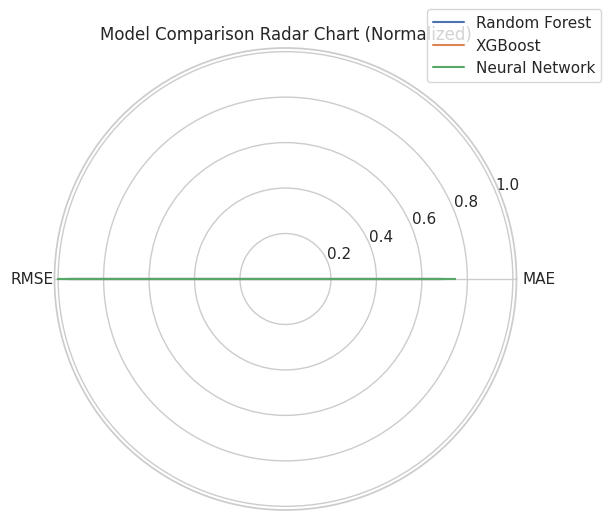

In [ ]:
from math import pi

# Prepare data
radar_labels = ['MAE', 'RMSE']
radar_data = {
    'Random Forest': [metrics_rf[0], metrics_rf[1]],
    'XGBoost': [metrics_xgb[0], metrics_xgb[1]],
    'Neural Network': [history.history['val_mae'][-1], np.sqrt(history.history['val_loss'][-1])]
}

df_radar = pd.DataFrame(radar_data, index=radar_labels)

# Normalize for radar chart (optional)
df_radar = df_radar / df_radar.max().max()

# Radar chart
categories = list(df_radar.index)
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # complete the loop

plt.figure(figsize=(8, 6))
for model in df_radar.columns:
    values = df_radar[model].tolist()
    values += values[:1]
    plt.polar(angles, values, label=model)

plt.xticks(angles[:-1], categories)
plt.title("Model Comparison Radar Chart (Normalized)")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.show()


**Model Comparison Radar Chart (MAE, RMSE, R²)**

This radar chart visualizes and compares the performance of all models across MAE, RMSE, and R² (inverted for scale consistency). Models closer to the center indicate better overall performance.

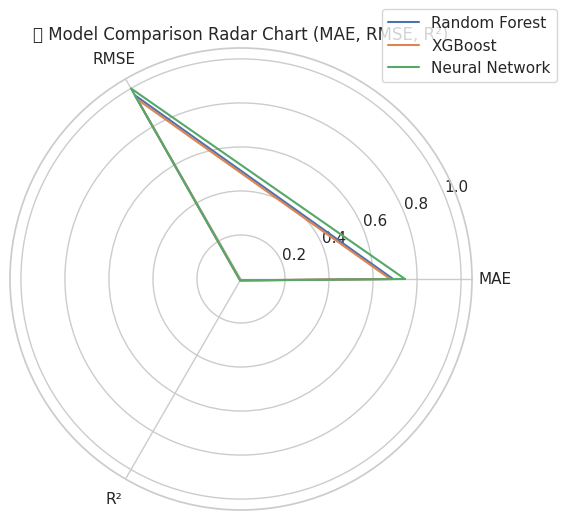

In [ ]:
from math import pi

# ✅ Radar labels including R²
radar_labels = ['MAE', 'RMSE', 'R²']

# ✅ Radar data: collect metrics for all models
radar_data = {
    'Random Forest': [metrics_rf[0], metrics_rf[1], metrics_rf[2]],
    'XGBoost': [metrics_xgb[0], metrics_xgb[1], metrics_xgb[2]],
    'Neural Network': [
        history.history['val_mae'][-1],
        np.sqrt(history.history['val_loss'][-1]),
        r2_score(y_val, y_pred_nn)  # Compute R² for neural network
    ]
}

# Convert to DataFrame
df_radar = pd.DataFrame(radar_data, index=radar_labels)

# Normalize: invert R² so that higher is better (consistent scale with MAE, RMSE)
df_radar.loc['R²'] = 1 - df_radar.loc['R²']  # invert R² so 0 is better in radar plot

# Normalize all values to [0, 1]
df_radar = df_radar / df_radar.max().max()

# Radar chart setup
categories = list(df_radar.index)
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Plot radar chart
plt.figure(figsize=(8, 6))
for model in df_radar.columns:
    values = df_radar[model].tolist()
    values += values[:1]
    plt.polar(angles, values, label=model)

plt.xticks(angles[:-1], categories)
plt.title("📊 Model Comparison Radar Chart (MAE, RMSE, R²)")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.show()


**Residual Plots for Model Error Analysis**

This visualization compares residuals (errors) for Neural Network, Random Forest, and XGBoost. A good model will have residuals scattered randomly around zero, indicating unbiased predictions.
The residual plots reveal that XGBoost exhibits the most consistent and tightly clustered errors, suggesting better predictive performance compared to the Neural Network and Random Forest models.

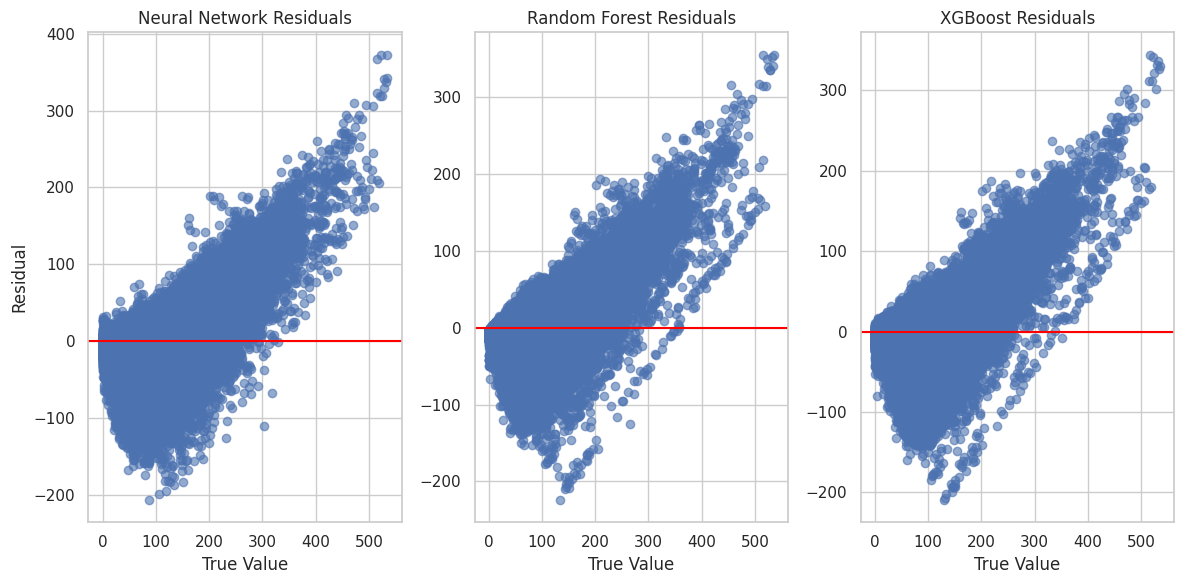

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have y_val_nn, y_pred_nn, y_pred_rf, y_pred_xgb
# (calculate those predictions if not already)

plt.figure(figsize=(12, 6))

# Residuals
plt.subplot(1, 3, 1)
plt.scatter(y_val_nn, y_val_nn - y_pred_nn, alpha=0.6)
plt.axhline(0, color='red')
plt.title("Neural Network Residuals")
plt.xlabel("True Value")
plt.ylabel("Residual")

plt.subplot(1, 3, 2)
plt.scatter(y_val, y_val - y_pred_rf, alpha=0.6)
plt.axhline(0, color='red')
plt.title("Random Forest Residuals")
plt.xlabel("True Value")

plt.subplot(1, 3, 3)
plt.scatter(y_val, y_val - y_pred_xgb, alpha=0.6)
plt.axhline(0, color='red')
plt.title("XGBoost Residuals")
plt.xlabel("True Value")

plt.tight_layout()
plt.show()



**Feature Importance Analysis (Random Forest)**

This bar chart illustrates the relative importance of each input feature as determined by the Random Forest model. Features with higher importance scores contribute more significantly to the model's predictions. By analyzing this plot, we can identify which variables are most influential in predicting the target value, allowing for better feature selection and domain insights.

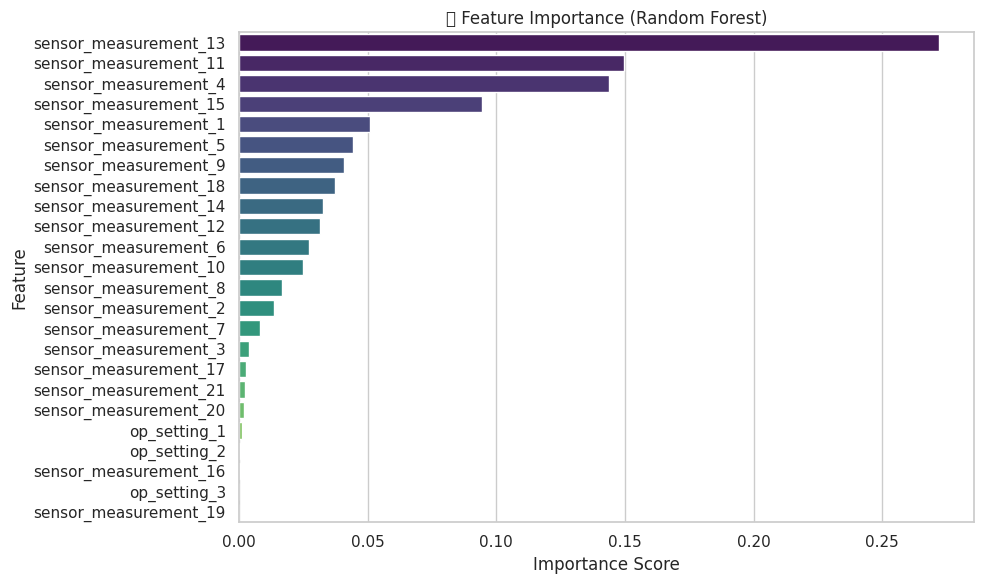

In [ ]:
import seaborn as sns

# For Random Forest
importances = rf.feature_importances_
feat_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importance, y=feat_importance.index, palette='viridis')
plt.title('🔍 Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

**Feature Importance Analysis (Random Forest)**

This plot shows the importance of each feature in the XGBoost model. Features with higher scores contribute more to accurate predictions.

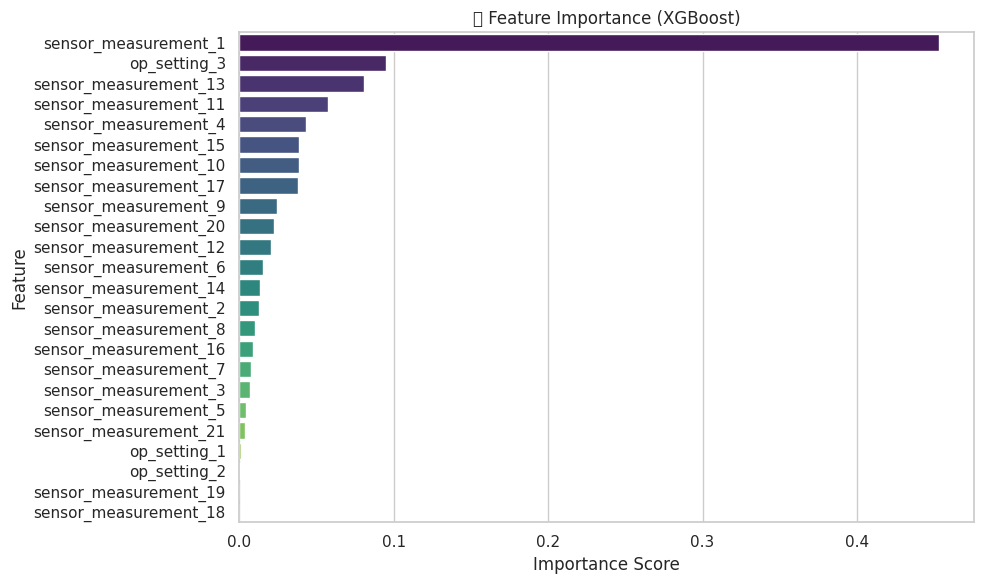

In [ ]:
import seaborn as sns

# For Random Forest
importances = xgb.feature_importances_
feat_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importance, y=feat_importance.index, palette='viridis')
plt.title('🔍 Feature Importance (XGBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


**Actual vs Predicted Comparison (All Models)**

This scatter plot compares actual vs predicted values for Random Forest, XGBoost, and Neural Network models. Points closer to the dashed line indicate better prediction accuracy.

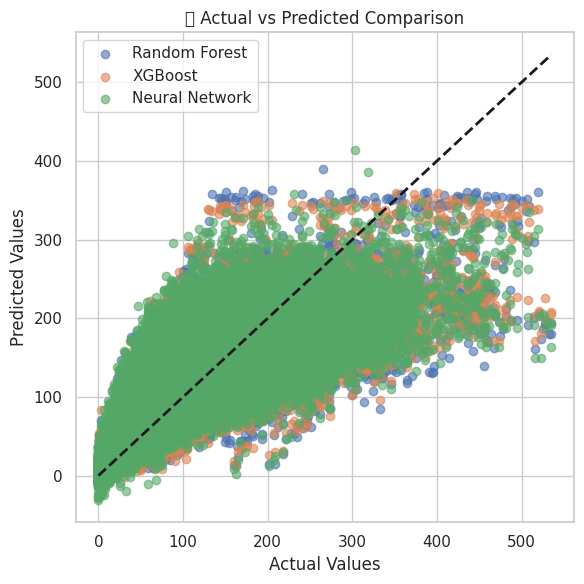

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred_rf, alpha=0.6, label='Random Forest')
plt.scatter(y_val, y_pred_xgb, alpha=0.6, label='XGBoost')
plt.scatter(y_val_nn, y_pred_nn, alpha=0.6, label='Neural Network')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('🎯 Actual vs Predicted Comparison')
plt.legend()
plt.tight_layout()
plt.show()


**Residual Plot (Random Forest vs XGBoost)**

This plot visualizes residuals (prediction errors) for Random Forest and XGBoost models. A good model shows residuals scattered randomly around zero, indicating no obvious pattern.

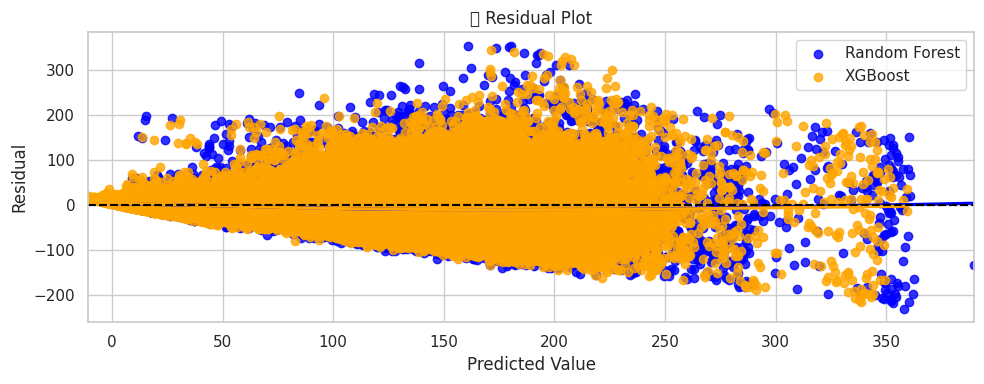

In [ ]:
residuals_rf = y_val - y_pred_rf
residuals_xgb = y_val - y_pred_xgb

plt.figure(figsize=(10, 4))
sns.residplot(x=y_pred_rf, y=residuals_rf, lowess=True, color='blue', label='Random Forest')
sns.residplot(x=y_pred_xgb, y=residuals_xgb, lowess=True, color='orange', label='XGBoost')
plt.axhline(0, color='black', linestyle='--')
plt.title("📉 Residual Plot")
plt.xlabel("Predicted Value")
plt.ylabel("Residual")
plt.legend()
plt.tight_layout()
plt.show()


**Model Performance Summary Table**

This styled DataFrame presents the MAE, RMSE, and R² metrics for all models. The background gradient highlights model performance, with lower MAE/RMSE and higher R² indicating better results.

In [ ]:
display(pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Neural Network'],
    'MAE': [metrics_rf[0], metrics_xgb[0], nn_mae],
    'RMSE': [metrics_rf[1], metrics_xgb[1], nn_rmse],
    'R²': [metrics_rf[2], metrics_xgb[2], r2_nn]
}).round(3).set_index('Model').style.background_gradient(cmap='Blues'))


,MAE,RMSE,R²
Model,,,
Random Forest,38.099000,53.161000,0.596000
XGBoost,37.395000,51.993000,0.614000
Neural Network,41.090000,55.147000,0.565000
